In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
#import matplotlib.pyplot as plt, mpld3
from geopandas import GeoDataFrame
from pyproj import Proj, transform
from sklearn.neighbors import KernelDensity
%matplotlib inline
#mpld3.enable_notebook()

In [2]:
%time df=pd.read_csv('311_Data_15_Complaint_Types.csv')
# %time df=pd.read_csv('data311na1.csv')

Wall time: 9.09 s


In [3]:
grid_size=1000
band=1100
# X=np.load('X.npy') # loads the X state coordinates
# Y=np.load('Y.npy') # loads the y state coordinates
longitude = np.load('Longitude.npy')
latitude = np.load('Latitude.npy')
row,col = latitude.shape; # rows and columns of the meshgrid
long_lat = np.vstack([latitude.ravel(), longitude.ravel()]).T # long_lat is a list of the 151x154 coordinates
kde = KernelDensity(bandwidth=band, metric='euclidean',kernel='gaussian', algorithm='ball_tree')

In [4]:
import sys
def KDE_month(temp):
    Xtrain = np.vstack([temp['data.311.Y.Coordinate..State.Plane.'], temp['data.311.X.Coordinate..State.Plane.']]).T
    kde.fit(Xtrain)
    Z_xy= np.exp(kde.score_samples(xy))
    Z = Z_xy.reshape(X.shape)*grid_size**2
    print ('\r'),
    print ('Test to make sure the sum is equal to 1:',Z.sum()),
    sys.stdout.flush()
    
    Zn=Z*len(temp)
    return Zn

In [24]:
list_names=np.load('list_names.npy')
list_names = np.delete(list_names, 5) #deleted Illegal Parking - missing one year of info
a=[]
for i in list_names:
    a.append(np.load('cube_'+i+'.npy'))

In [6]:
list_names

array(['Noise - Residential', 'Street Condition', 'PLUMBING',
       'Blocked Driveway', 'Water System', 'Street Light Condition',
       'Noise', 'ELECTRIC', 'Dirty Conditions', 'Noise - Commercial',
       'Damaged Tree', 'Sanitation Condition', 'Traffic Signal Condition',
       'Rodent'], 
      dtype='<U24')

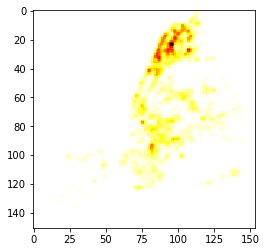

In [7]:
plt.set_cmap('hot_r')
plt.imshow(a[0][0,:,:], interpolation='nearest')

In [8]:
w=np.zeros(a[0].shape)
for d in range(a[0].shape[0]):
#    print (d),
#    print ('\r'),
    for r in range(a[0].shape[1]):
        for c in range(a[0].shape[2]):
            w[d,r,c]=np.median([a[i][d,r,c] for i in range(len(a))])  

In [19]:
w_all=w[:,:,:].sum(0)
w_all/=w_all.max()
w_all[w_all<0.01] = 0
w_all.max()

1.0

In [10]:
w_all.shape

(151, 154)

In [11]:
noise = a[0][0]/w_all
noise = np.nan_to_num(noise)
#noise[noise < 0.01] = 0

C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


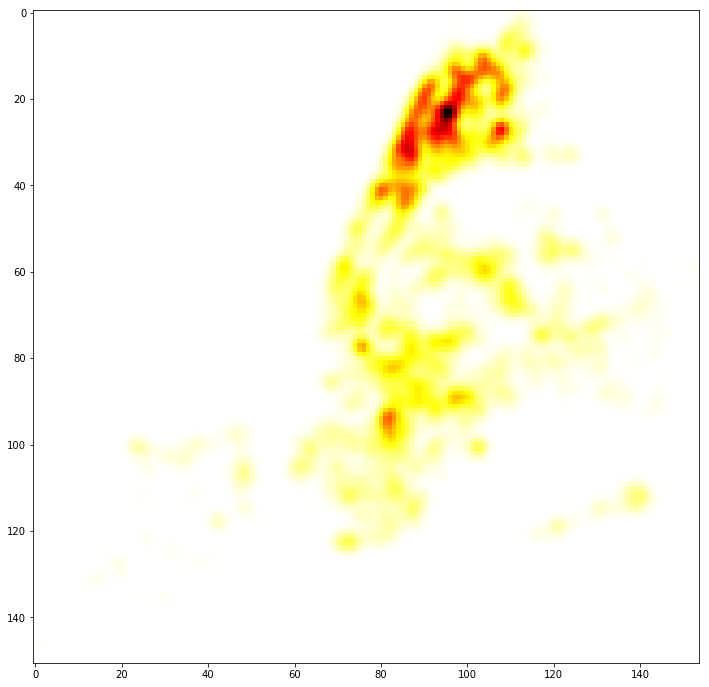

In [12]:
img = ndimage.gaussian_filter(a[0][0], sigma=(1, 1), order=0)
plt.figure(figsize=(12,12))
plt.imshow(img, interpolation='nearest')
plt.show()

In [13]:
boros = GeoDataFrame.from_file('nyc.shp')
boros.crs = '+proj=lcc +lat_1=41.03333333333333 +lat_2=40.66666666666666 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000.0000000001 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs '
boros.to_crs(crs=None, epsg=4326, inplace=True)

In [14]:
# X=np.load('X.npy')
# Y=np.load('Y.npy')
# inProj = Proj(init='EPSG:2263' , preserve_units=True )
# outProj= Proj(init='epsg:4326')
# x2,y2=transform(inProj,outProj,X,Y)

In [15]:
a[0].shape

(84, 151, 154)

In [16]:
zn = a[0][0]
zn[zn <0.1] = 0
zn /= w_all
zn = np.nan_to_num(zn)

C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


C:\Users\maism\Anaconda3\lib\site-packages\matplotlib\colors.py:859: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


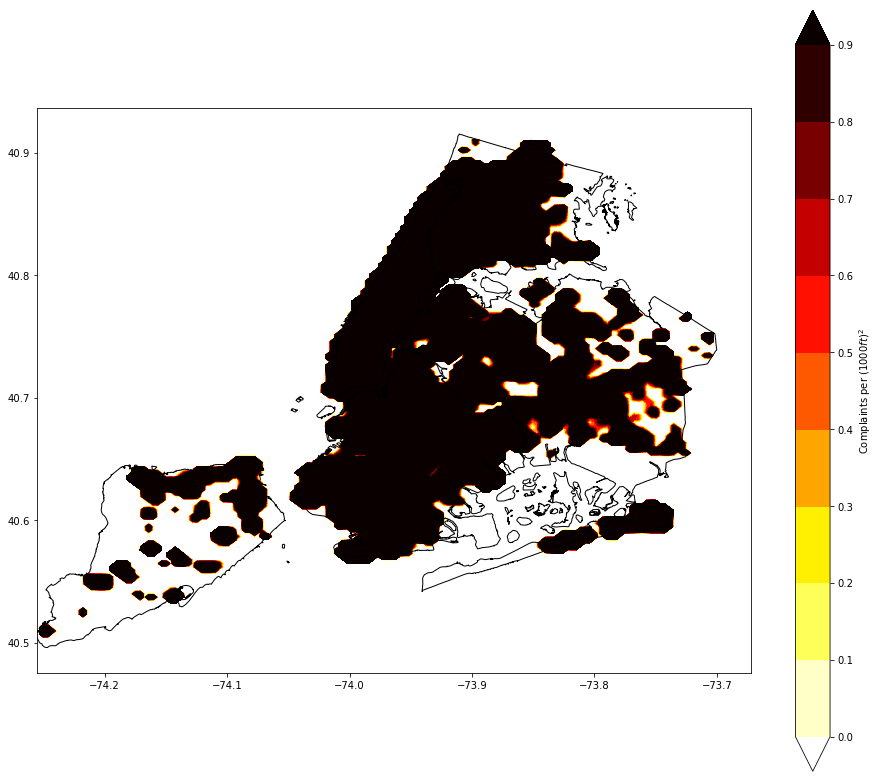

In [27]:
plt.rcParams['figure.figsize']=(16,14)
boros.plot(alpha=0.0)
levels =np.arange(0,1,.1)
CS1=plt.contourf(longitude, latitude, zn, levels=levels, cmap=plt.cm.hot_r,extend='both')
CS1.cmap.set_under('w')
cbar = plt.colorbar(CS1)
cbar.ax.set_ylabel('Complaints per $(1000 ft)^2$')
#plt.rcParams['figure.figsize']=(6,4)

In [32]:
X=np.load('X.npy')
Y=np.load('Y.npy')

In [33]:
def plot_normalized_complaint_type(complaint_type,i,ax):
    temp=complaint_type[i,:,:]
    temp[temp<.01]=0
    levels =np.arange(0,5,1)
    CS1=ax.contourf(X, Y, temp, levels=levels, cmap=plt.cm.OrRd,extend='both')
    CS1.cmap.set_under('w')
    #cbar = plt.colorbar(CS1)
    #cbar.ax.set_ylabel('Complaints per $(1000 ft)^2$')
    ax.axis('off')
#    ax.set_title(list_names[complaint_type_index]+', Month: '+str(i))
    ax.set_title('Noise - R'+', MM: '+str(i))

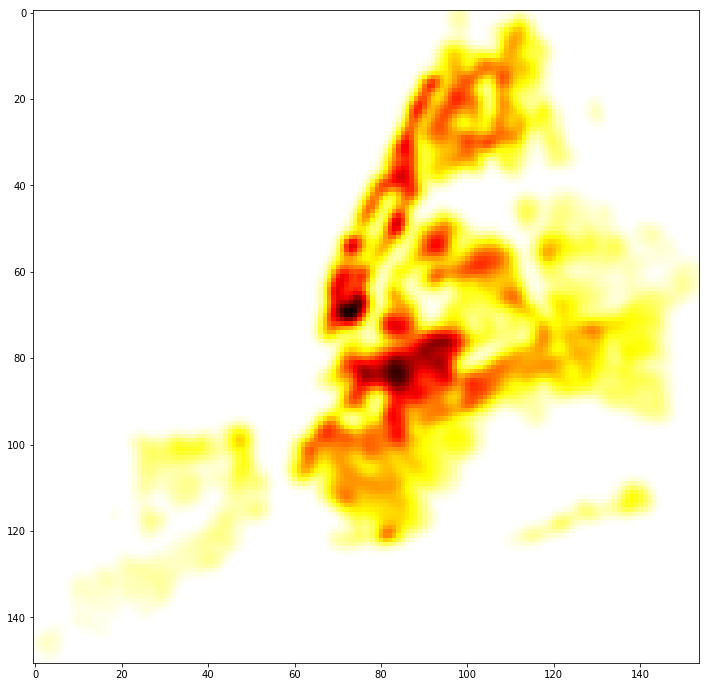

In [35]:
import scipy.ndimage as ndimage
img = ndimage.gaussian_filter(w_all, sigma=(1, 1), order=0)
img[img<10**-3]=0
plt.set_cmap('hot_r')
plt.figure(figsize=(12,12))
plt.imshow(img, interpolation='nearest')
plt.show()

C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\maism\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


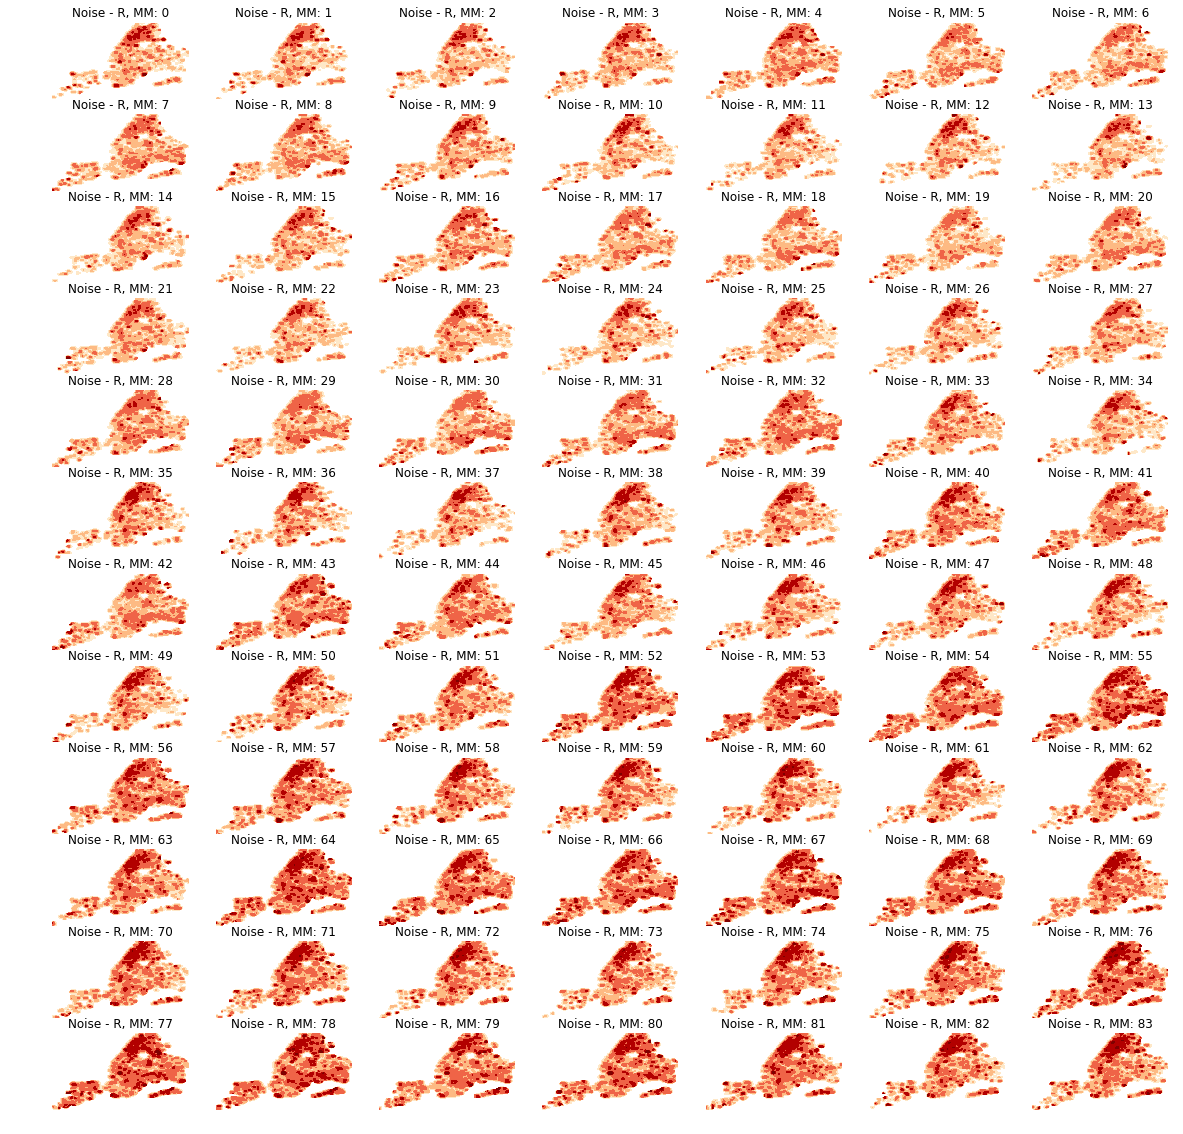

In [36]:
# Noise Residential Normalized
noise_normalized = a[0]/img
noise_normalized = np.log(noise_normalized)
noise_normalized[noise_normalized==np.inf]=0
fig, axs = plt.subplots(12, 7,figsize=(20,20))
for ax, i in zip(axs.ravel(), range(84)):
    plot_normalized_complaint_type(noise_normalized,i,ax)